# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     |████████████████████████████████| 88 kB 3.4 MB/s 
     |████████████████████████████████| 58 kB 6.2 MB/s 
     |████████████████████████████████| 376 kB 37.6 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=910514d3ecce98f2cd3ea285f65c8cd5022773068ec7a4c146cd358c410091cd
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=82bcd8d903453bf00223b765471fb914ffbf440ea5b60380959e4fceeb70718c
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-skfs9njt
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-skfs9njt
   

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 27.25 MiB/s, done.
Resolving deltas: 100% (3/3), done.


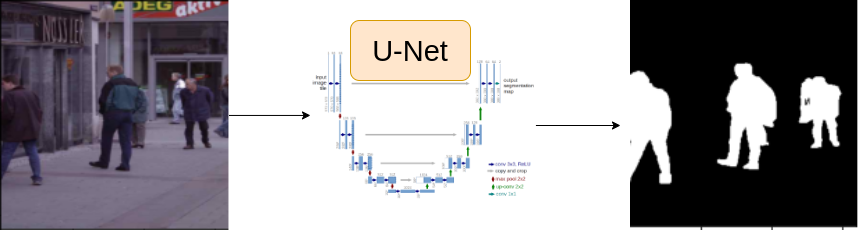

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [20]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [7]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [11]:
row = df.iloc[0]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

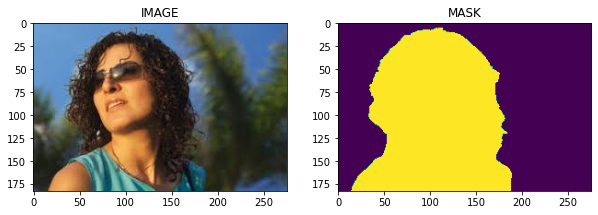

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask)

In [13]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [15]:
import albumentations as A

In [16]:
def get_train_augs():
  return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
  ])


# Task 4 : Create Custom Dataset 

In [17]:
from torch.utils.data import Dataset

In [18]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h,w,c)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    #(h, w, c) -> (c, h, w) as pytorch uses c,h,w convention, we must change it.


    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    #convert numpy to tensor
    #divide by 255.0 to have values between 0 & 1
    #round of mask values 
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [21]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [22]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


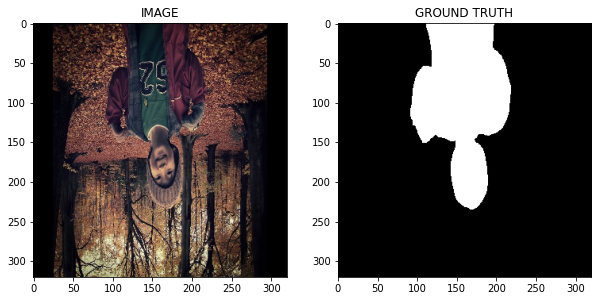

In [26]:
idx = 21

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [27]:
from torch.utils.data import DataLoader

In [28]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [30]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [31]:
for image, mask in trainloader:
  break

print(f"one batch image shape : {image.shape}")
print(f"one batch mask shape : {mask.shape}")

one batch image shape : torch.Size([16, 3, 320, 320])
one batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [32]:
from torch import nn
import segmentation_models_pytorch as smp 
from segmentation_models_pytorch.losses import DiceLoss

In [33]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3, # RGB images so "3"
        classes = 1, #bcoz binary classification
        activation = None #we not used any sigmoid or softmax function so output will be raw 'logits'
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits
    

In [34]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

# Task 7 : Create Train and Validation Function 

In [35]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)
  

In [37]:
def eval_fn(data_loader, model):

  model.train()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [39]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model) 
  
  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED-MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:01<00:00,  2.53it/s]


SAVED-MODEL
Epoch : 1 Train_loss : 0.7206725974877676 Valid_loss : 0.42922304570674896


100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


SAVED-MODEL
Epoch : 2 Train_loss : 0.3387294501066208 Valid_loss : 0.4030121713876724


100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


Epoch : 3 Train_loss : 0.2798052380482356 Valid_loss : 0.4340718388557434


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


SAVED-MODEL
Epoch : 4 Train_loss : 0.3098307033379873 Valid_loss : 0.36043211817741394


100%|██████████| 4/4 [00:01<00:00,  2.60it/s]


SAVED-MODEL
Epoch : 5 Train_loss : 0.26791930198669434 Valid_loss : 0.32933372631669044


100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


Epoch : 6 Train_loss : 0.21800791670878727 Valid_loss : 0.374279223382473


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


SAVED-MODEL
Epoch : 7 Train_loss : 0.2444271485010783 Valid_loss : 0.29227155819535255


100%|██████████| 4/4 [00:01<00:00,  2.52it/s]


SAVED-MODEL
Epoch : 8 Train_loss : 0.2010659803946813 Valid_loss : 0.27460356056690216


100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


Epoch : 9 Train_loss : 0.17407251596450807 Valid_loss : 0.32349811494350433


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Epoch : 10 Train_loss : 0.18305491507053376 Valid_loss : 0.3076774887740612


100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


Epoch : 11 Train_loss : 0.15451583216587703 Valid_loss : 0.37348373234272003


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Epoch : 12 Train_loss : 0.16410237948099773 Valid_loss : 0.33332765102386475


100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


Epoch : 13 Train_loss : 0.17403699904680253 Valid_loss : 0.4452875852584839


100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


Epoch : 14 Train_loss : 0.2261710117260615 Valid_loss : 0.4357553496956825


100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


Epoch : 15 Train_loss : 0.2361039400100708 Valid_loss : 0.3196764141321182


100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


Epoch : 16 Train_loss : 0.16904156555732092 Valid_loss : 0.2755770981311798


100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


Epoch : 17 Train_loss : 0.14646332810322443 Valid_loss : 0.289858877658844


100%|██████████| 4/4 [00:01<00:00,  2.60it/s]


SAVED-MODEL
Epoch : 18 Train_loss : 0.17061723818381627 Valid_loss : 0.24577665328979492


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Epoch : 19 Train_loss : 0.13553824424743652 Valid_loss : 0.3366033658385277


100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


Epoch : 20 Train_loss : 0.11795010070006053 Valid_loss : 0.2976315915584564


100%|██████████| 4/4 [00:01<00:00,  2.53it/s]


Epoch : 21 Train_loss : 0.12533541520436606 Valid_loss : 0.3116866201162338


100%|██████████| 4/4 [00:01<00:00,  2.52it/s]


Epoch : 22 Train_loss : 0.10796316961447398 Valid_loss : 0.29912029951810837


100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


Epoch : 23 Train_loss : 0.09528727134068807 Valid_loss : 0.26482750475406647


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


Epoch : 24 Train_loss : 0.1036289801200231 Valid_loss : 0.3059130162000656


100%|██████████| 4/4 [00:01<00:00,  2.63it/s]

Epoch : 25 Train_loss : 0.09050884942213694 Valid_loss : 0.2877724766731262


# Task 9 : Inference

In [42]:
idx = 2

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

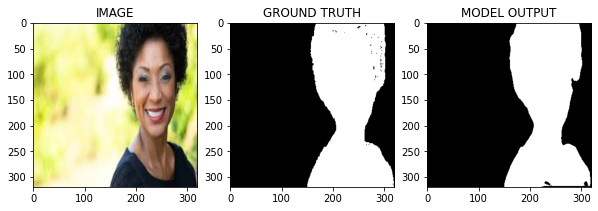

In [43]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya